In [15]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Playoff Team Predictor
## Custom Naive Bayes Functions

In [16]:
def p_x_given_class(obs_row, feature, class_,aggs):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]

    obs = obs_row[feature] #observation
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

def predict_class(obs_row,y_train,aggs,target_col=[0,1]):
    c_probs = []
    features_0 = {}
    features_1 = {}
    
    for i in range(len(target_col)):
        c = target_col[i]
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c,aggs)
        c_probs.append(p)
    
    return target_col[np.argmax(c_probs)]

def predict_class2(obs_row,y_train,aggs,target_col=[0,1]):
    c_probs = []
    features_0 = {}
    features_1 = {}
    
    for i in range(len(target_col)):
        c = target_col[i]
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c,aggs)
            if c == target_col[0]:
                features_0[feature]=p_x_given_class(obs_row, feature, c,aggs)
            elif c==target_col[1]:
                features_1[feature]=p_x_given_class(obs_row, feature, c,aggs)
        c_probs.append(p)
    
    return target_col[np.argmax(c_probs)] , features_0, features_1

def nba_stat_plot(bag,category,split_type):
    ind_cat=sorted(bag, key=bag.get,reverse =True)
    ind_val=sorted(bag.values(), reverse=True)
    stats = pd.DataFrame(list(zip(ind_cat,ind_val)),columns=['Stats','Count'])
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=stats['Stats'],y=stats['Count'],palette ="RdBu")
    ax.set_title(f'{category} Stat Indictors on {split_type} Data')

In [17]:
df = pd.read_csv('NBA_team_stats_1980to2019.csv',index_col=0)
print(len(df))
df.head()

1015


,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,AST,STL,BLK,TOV,PF,PTS,Playoff,Location,Year,Conference
0,Spurs,82,240.9,47.0,94.4,0.498,0.6,2.5,0.252,46.4,...,28.4,9.4,4.1,19.4,25.6,119.4,True,San Antonio,1980,Western
1,Lakers,82,242.4,47.5,89.9,0.529,0.2,1.2,0.200,47.3,...,29.4,9.4,6.7,20.0,21.8,115.1,True,Los Angeles,1980,Western
2,Cavaliers,82,243.0,46.5,98.1,0.474,0.4,2.3,0.193,46.0,...,25.7,9.3,4.2,16.7,23.6,114.1,False,Cleveland,1980,Eastern
3,Knicks,82,241.2,46.4,93.6,0.496,0.5,2.3,0.220,45.9,...,27.6,10.7,5.6,19.7,26.4,114.0,False,New York,1980,Eastern
4,Celtics,82,242.4,44.1,90.1,0.490,2.0,5.1,0.384,42.1,...,26.8,9.9,3.8,18.8,24.1,113.5,True,Boston,1980,Eastern


In [18]:
X = df[[col for col in df.columns if col != 'Playoff' and col != 'Team' and 
        col != 'Location' and col != 'Conference' and col != 'G' and col != 'MP']]
y = df.Playoff
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)

In [19]:
train = pd.concat([X_train, y_train], axis=1)
aggs = train.groupby('Playoff').agg(['mean', 'std'])
aggs

FG                  FGA                 FG%            \
              mean       std       mean       std      mean       std   
Playoff                                                                 
False    38.103313  3.099277  84.121386  4.567466  0.452533  0.019011   
True     39.298135  3.396878  83.664569  4.828653  0.469247  0.020738   

               3P                  3PA            ...       BLK            \
             mean       std       mean       std  ...      mean       std   
Playoff                                           ...                       
False    5.027410  2.993538  14.613554  8.224528  ...  4.906325  0.921015   
True     5.030769  3.200888  14.125175  8.480900  ...  5.299534  0.988580   

               TOV                   PF                   PTS            \
              mean       std       mean       std        mean       std   
Playoff                                                                   
False    15.789157  1.763169  22.535542  2.238135   99.934036  6.607143   
True     15.298834  1.777001  22.063170  2.338982  103.548951  7.173301   

                Year             
                mean        std  
Playoff                          
False    2002.207831  11.615525  
True     2000.207459  11.303640  

[2 rows x 44 columns]

In [20]:
y_hat_train =[]
y_hat_test=[]
feat0_train=[]
feat1_train=[]
feat0_test=[]
feat1_test=[]
bag1_train={}
bag2_train={}
bag3_train={}
bag1_test={}
bag2_test={}
bag3_test={}

for i,idx in enumerate(range(len(X_train))):
    a,b,c=predict_class2(X_train.iloc[idx],y_train,aggs)
    y_hat_train.append(a)
    feat0_train.append(b)
    feat1_train.append(c)
    
    difference = {key: abs((feat0_train[i][key] - feat1_train[i].get(key,0)))/((feat0_train[i][key]+feat1_train[i].get(key,0))/2) for key in feat0_train[i].keys()}
    x=sorted(difference, key=difference.get,reverse =True)
    y=sorted(difference.values(), reverse=True)
    bag1_train[x[0]]=bag1_train.get(x[0],0)+1
    bag2_train[x[1]]=bag2_train.get(x[1],0)+1
    bag3_train[x[2]]=bag3_train.get(x[2],0)+1

for i,idx in enumerate(range(len(X_test))):
    a,b,c=predict_class2(X_test.iloc[idx],y_train,aggs)
    y_hat_test.append(a)
    feat0_test.append(b)
    feat1_test.append(c)
    
    difference = {key: abs((feat0_test[i][key] - feat1_test[i].get(key,0)))/((feat0_test[i][key]+feat1_test[i].get(key,0))/2) for key in feat0_test[i].keys()}
    x=sorted(difference, key=difference.get,reverse =True)
    y=sorted(difference.values(), reverse=True)
    bag1_test[x[0]]=bag1_test.get(x[0],0)+1
    bag2_test[x[1]]=bag2_test.get(x[1],0)+1
    bag3_test[x[2]]=bag3_test.get(x[2],0)+1   

#m, y_hat_train = [predict_class(X_train.iloc[idx],target_col) for idx in range(len(X_train))]
# y_hat_test = [predict_class(X_test.iloc[idx],target_col) for idx in range(len(X_test))]

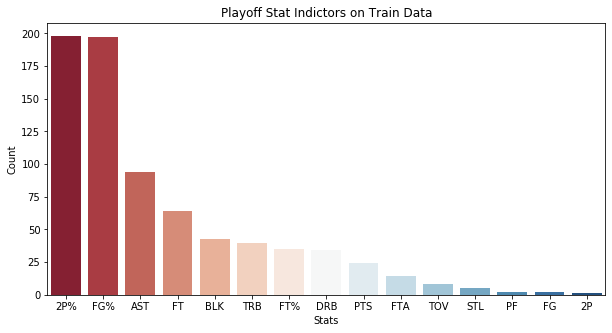

In [21]:
nba_stat_plot(bag1_train,'Playoff',"Train")

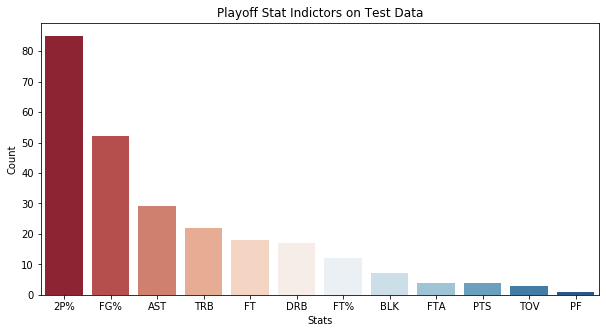

In [22]:
nba_stat_plot(bag1_test,'Playoff','Test')

In [23]:
residuals_train = y_hat_train == y_train
acc_train = residuals_train.sum()/len(residuals_train)

residuals_test = y_hat_test == y_test
acc_test = residuals_test.sum()/len(residuals_test)

print(f'Correct Train Predict: {residuals_train.sum()}\t Wrong Train Predict: {len(residuals_train)-residuals_train.sum()}')
print(f'Correct Test Predict: {residuals_test.sum()}\t Wrong Test Predict: {len(residuals_test)-residuals_test.sum()}')
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(acc_train, acc_test))

Correct Train Predict: 504	 Wrong Train Predict: 257
Correct Test Predict: 179	 Wrong Test Predict: 75
Training Accuracy: 0.6622864651773982	Testing Accuracy: 0.7047244094488189


## Gaussian Naive Bayes with Sklearn

In [24]:
model = GaussianNB()
y_train2 =y_train.astype(int)
y_test2 = y_test.astype(int)

model.fit(X_train, y_train2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [25]:
y_train_predict=model.predict(X_train)
y_test_predict2=model.predict(X_test)

In [26]:
print("Sklearn Train Accuracy:",metrics.accuracy_score(y_train2, y_train_predict))
print("Sklearn Test Accuracy:",metrics.accuracy_score(y_test2, y_test_predict2))

Sklearn Train Accuracy: 0.6622864651773982
Sklearn Test Accuracy: 0.7047244094488189


In [27]:
print('Sklearn Train ROC score: ',metrics.roc_auc_score(y_train2, y_train_predict))
print('Sklearn Test ROC score: ',metrics.roc_auc_score(y_test2, y_test_predict2))

Sklearn Train ROC score:  0.6694786137557222
Sklearn Test ROC score:  0.7281363786825554
